In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os 
from dotenv import load_dotenv

import requests
import json

from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

import tensorflow as tf
import tensorflow_hub as hub

import openai

from sklearn.metrics.pairwise import cosine_similarity



In [2]:
model_name = "iarfmoose/t5-base-question-generator"

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

URL = "https://api.openai.com/v1/chat/completions"

2023-08-30 15:21:10.192037: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-30 15:21:10.192067: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-30 15:21:10.192074: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-30 15:21:10.192112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-30 15:21:10.192132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-08-30 15:21:13.962371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [3]:
# remove review with too many or too few words. 
df = pd.read_csv('archive/train_40k.csv')
df['text_len'] = df['Text'].apply(len)
df = df.sort_values('text_len', ascending=False)
df = df.loc[df['text_len'] >= 400] # min words
df = df.loc[df['text_len'] <= 1000] # max words

(array([2631., 2315., 1833., 1527., 1187.,  942.,  842.,  677.,  550.,
         500.]),
 array([ 400.,  460.,  520.,  580.,  640.,  700.,  760.,  820.,  880.,
         940., 1000.]),
 <BarContainer object of 10 artists>)

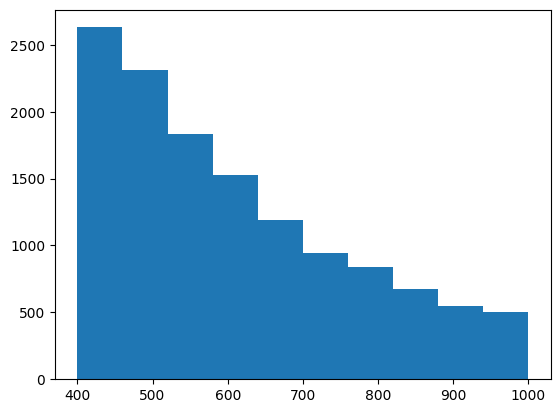

In [4]:
# historgrams of reviews by text length.
plt.hist(df['text_len'], bins = 10)

In [5]:
# Reduce data the individual product with the most reviews.
most_reviewed = df.groupby('productId')['text_len'].count().idxmax()
df = df.loc[df['productId'] == most_reviewed]

(array([11., 11.,  7.,  9.,  2.,  3.,  4.,  3.,  4.,  2.]),
 array([409. , 466.3, 523.6, 580.9, 638.2, 695.5, 752.8, 810.1, 867.4,
        924.7, 982. ]),
 <BarContainer object of 10 artists>)

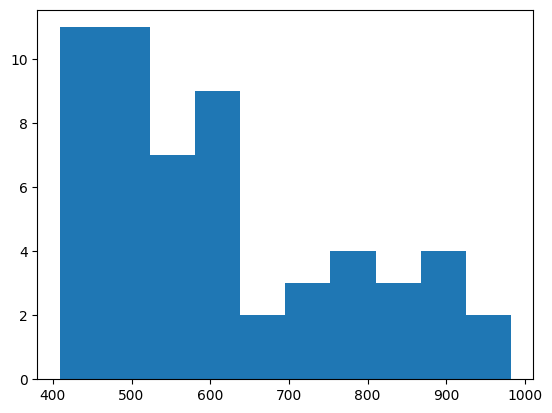

In [6]:
plt.hist(df['text_len'], bins = 10)

In [7]:
question_generator = pipeline(model=model_name)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at iarfmoose/t5-base-question-generator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=True`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [83]:
# use model to generate questions potentially answered by review content.
def generate_questions(input_text):
    outputs = question_generator(input_text, num_return_sequences = 3, num_beams = 20, truncation=True)    
    generated_questions = []
    for index, question in enumerate(outputs):
        generated_questions.append(question['generated_text'])
    return generated_questions

In [84]:
df['questions'] = df['Text'].apply(generate_questions)

In [85]:
def question_embedder(question_list):
    question_embeddings = []
    for question in question_list:
        question_embeddings.append(embed([question]).numpy())
    return question_embeddings

df['question_embeddings'] = df['questions'].apply(question_embedder)

In [86]:
topic = df['Title'].iloc[0]
query = input(f'Ask us a question about our {topic}.')

query_embedding = embed([query]).numpy()

In [87]:
def embedding_similarity_test(query_embedding, embedding_list):
    temp_similarities = []
    for embedding in embedding_list:
        similarity = cosine_similarity(query_embedding, embedding)
        temp_similarities.append(similarity)
    avg_similarity = sum(temp_similarities) / len(temp_similarities)
    return avg_similarity

df['similarity'] = df['question_embeddings'].apply(lambda x: embedding_similarity_test(query_embedding=query_embedding, embedding_list= x))

In [88]:
all_embeddings_list = []
for row in df['question_embeddings']:
    for embedding in row:
        all_embeddings_list.append(embedding)

#plt.hist(all_embeddings_list, bins = 10)

In [89]:
from sklearn.decomposition import PCA

demension_reducer = PCA(n_components=1)

dimentionally_reduced_list = demension_reducer.fit_transform(X=np.vstack(all_embeddings_list))

#dimentionally_reduced_list = [] 
#for vector in all_embeddings_list:
#    reduced_vector = demension_reducer.fit_transform(vector)
#    dimentionally_reduced_list.append(reduced_vector)


#for i in dimentionally_reduced_list:
#    plt.hist(i, bins = 300)

In [77]:
#max(dimentionally_reduced_list) - min(dimentionally_reduced_list)

array([1.0847515], dtype=float32)

In [90]:
max(dimentionally_reduced_list) - min(dimentionally_reduced_list)

array([1.0422931], dtype=float32)

(array([45.,  5., 10., 15.,  7., 15.,  7., 12.,  4., 10., 14.,  1.,  4.,
         0.,  4.,  7.,  7.,  1.]),
 array([-0.3511875 , -0.29092354, -0.23065956, -0.17039558, -0.11013162,
        -0.04986765,  0.01039632,  0.07066029,  0.13092425,  0.19118823,
         0.25145221,  0.31171617,  0.37198013,  0.43224412,  0.49250808,
         0.55277205,  0.61303604,  0.67329997,  0.73356396]),
 <BarContainer object of 18 artists>)

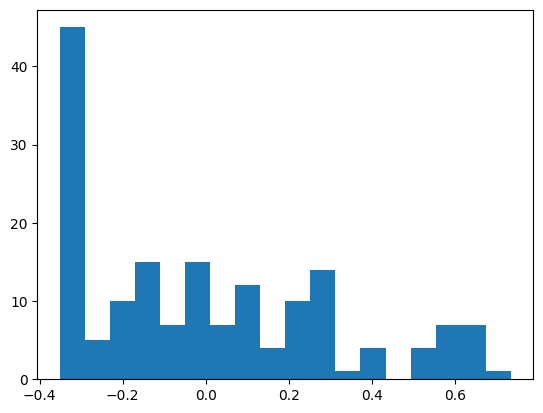

In [82]:
#plt.hist(dimentionally_reduced_list, bins=18)

(array([42.,  5., 12.,  7., 19.,  4., 14.,  7., 12.,  6., 13.,  5.,  0.,
         5.,  0.,  1.,  9.,  7.]),
 array([-0.35438102, -0.29647586, -0.23857068, -0.18066551, -0.12276033,
        -0.06485516, -0.00694998,  0.05095519,  0.10886037,  0.16676554,
         0.22467071,  0.28257588,  0.34048107,  0.39838624,  0.45629141,
         0.51419657,  0.57210177,  0.63000691,  0.68791211]),
 <BarContainer object of 18 artists>)

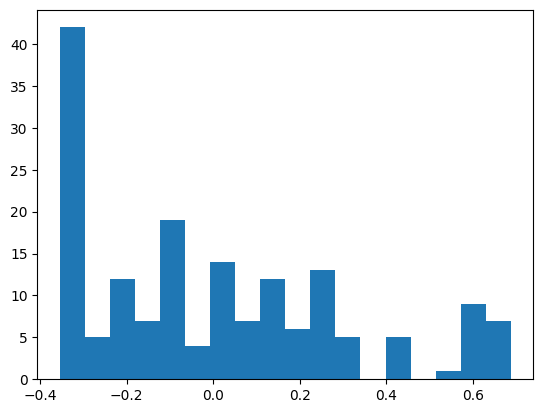

In [91]:
plt.hist(dimentionally_reduced_list, bins=18)

In [13]:
df_similarity_sorted = df.sort_values(by='similarity', ascending=False)
most_similar_indexes = df_similarity_sorted.index[:3]

query_related_text = []
for index in most_similar_indexes:
    query_related_text.append(f"{df['Text'].loc[index]}")

In [14]:
load_dotenv()
openai.api_key = os.environ.get('api_key')

prompt = f'''You are a firendly product expert. I ask the question {query}. 
Please read the following text: {query_related_text}, and give a max 3 sentance summary 
response using only the text given. If the question does not seem to 
match with the availble information, tell me explicitly and also mention the sections 
of the question which do not match. Do not mention that you are referencing any text. 
YOU are the expert. '''

messages = [
    {"role": "system", "content": prompt},
    {"role": "user", "content": 'start'}
]

payload = {
    'model': 'gpt-3.5-turbo',
    'messages': messages,
    "temperature" : 1.0,
    "top_p":1.0,
    "n" : 1,
    "stream": False,
    "presence_penalty":0.1,
    "frequency_penalty":0.1,
}

headers = {
"Content-Type": "application/json",
"Authorization": f"Bearer {openai.api_key}"
}

In [15]:
response = requests.post(URL, headers=headers, json=payload, stream=False)
parsed_response = json.loads(response.content)
reply = parsed_response['choices'][0]['message']
reply_content = reply['content']

print(reply_content)


Based on the available information, there is no specific mention of the exact number of diapers the diaper pail can hold. However, multiple reviews highlight that it can hold a lot of diapers and is capable of fixing any problems if one gets stuck. It is also mentioned that the diaper pail can be easily operated with one hand, allowing parents to hold onto their baby.
